# Config

In [8]:
import numpy as np
import matplotlib.pyplot as plt

M = 4
T=1
NL = 10000
SEED=42
np.random.seed(SEED)

# Utility

In [3]:
def h(l, T=1):
    return M**(-l)*T
   
def optimal_N(V, err=1e-4):
    temp = 0
    for i in range(len(V)):
        temp += np.sqrt(V[i]/h(i))
        
    return [int(2*err**(-2)*np.sqrt(V[i]*h(i))*temp) for i in range(len(V))]

# MLMC

In [4]:
def mlmc(sim_method, L=5, err=1e-4):
    V = []
    V2 = [0]
    N = []
    P = []
    Pa = []
    Y = [0]
    l = 0
    converge = False
    
    W = [np.sqrt(M**(-4)) * np.random.randn(NL) for _ in range(int(M**4))]

    W_l_dict = {L-1: W}

    for l in range(L-2, -1, -1):
        dt_l = h(l)
        n_steps_l = int(T / dt_l)
        W_l_dict[l] = [sum(W_l_dict[l+1][i*M : (i+1)*M]) for i in range(n_steps_l)]

    while (l < 2 or not converge) and l<L:
    #while l < L:
        pl, vl, parray = sim_method(W_l_dict[l], dt=h(l))
        #pl, vl, parray = sim_method(dt=h(l))
        P.append(pl)
        V.append(vl)
        Pa.append(parray)
        
        N = optimal_N(V, err)
        Nl = N[-1]
        
        if l >= 1:
            Yl = np.mean(Pa[l][:Nl]-Pa[l-1][:Nl])
            v2 = np.var(Pa[l][:Nl]-Pa[l-1][:Nl])
            Y.append(Yl)
            V2.append(v2)
            if l >= 2:
                converge = (max(Y[l-1]/M, Y[l]) < err*(M-1)/np.sqrt(2))
        
        l += 1
    
    return V, V2, P, Y, N

# 1. GBM

$dS = rSdt + \sigma SdW, 0<t<1$

## 1.1 European Option

$P = exp(-r)max(0, S(1)-1)$

In [6]:
def sim_euro(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1, K=1):
    S = np.full((n_paths,), S0, dtype=np.float64)
    
    n_steps = int(T/dt)
    for i in range(n_steps):
        #dW = np.sqrt(dt) * np.random.randn(n_paths)
        S += r * S * dt + sigma * S * dW[i]
    
    payoffs = np.exp(-r * T) * np.maximum(0, S - K)
    
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)

    return price, variance, payoffs

In [90]:
V, V2, P, Y, N = mlmc(sim_euro)

C:\Users\Nvve\AppData\Local\Temp\ipykernel_20272\1745132279.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(V2) / np.log(4), label='log4(V2)', marker='s')


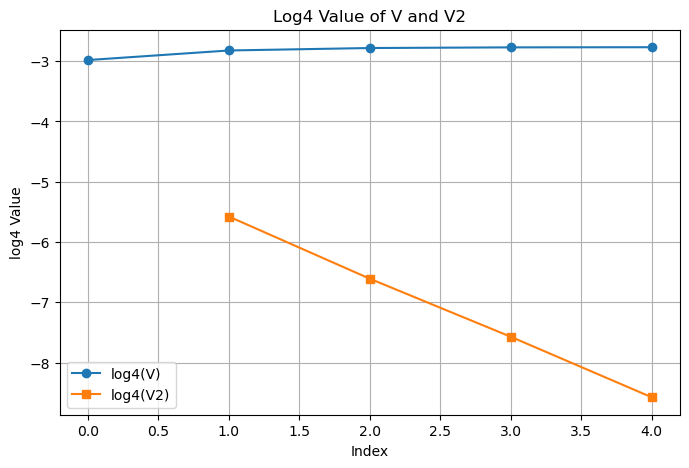

In [91]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(V) / np.log(4), label='log4(V)', marker='o')
plt.plot(np.log(V2) / np.log(4), label='log4(V2)', marker='s')


plt.xlabel("Index")
plt.ylabel("log4 Value")
plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_20272\665671232.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(P2) / np.log(4), label='log4(V2)', marker='s')
C:\Users\Nvve\AppData\Local\Temp\ipykernel_20272\665671232.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y2) / np.log(4), label='log4(Y2)', marker='s')


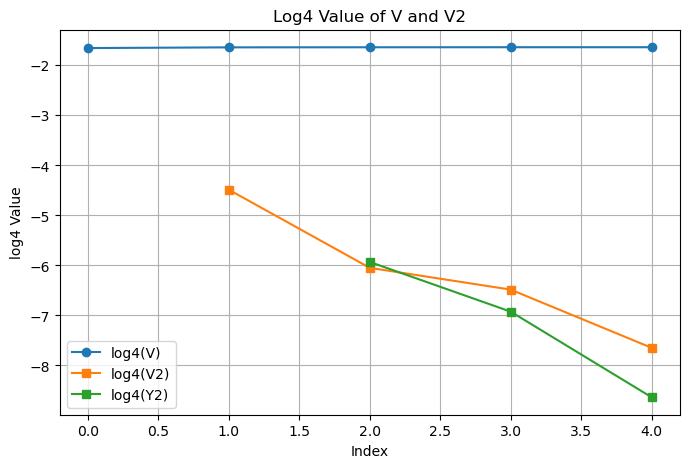

In [96]:
#P2 = [0]+[P[i]-P[i-1] for i in range(1, 5)]
Y2 = [0, 0] + [abs(Y[i]-Y[i-1]/4) for i in range(2, 5)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(P) / np.log(4), label='log4(V)', marker='o')
plt.plot(np.log(Y) / np.log(4), label='log4(P2)', marker='s')
plt.plot(np.log(Y2) / np.log(4), label='log4(Y2)', marker='x')

plt.xlabel("Index")
plt.ylabel("log4 Value")
plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

In [9]:
Nlist = []
errs = [0.001, 0.0005, 0.0001, 0.0002, 0.00005]
for err in errs:
    _, _, _, _, Nx = mlmc(sim_euro, err=err)
    Nlist.append(Nx)

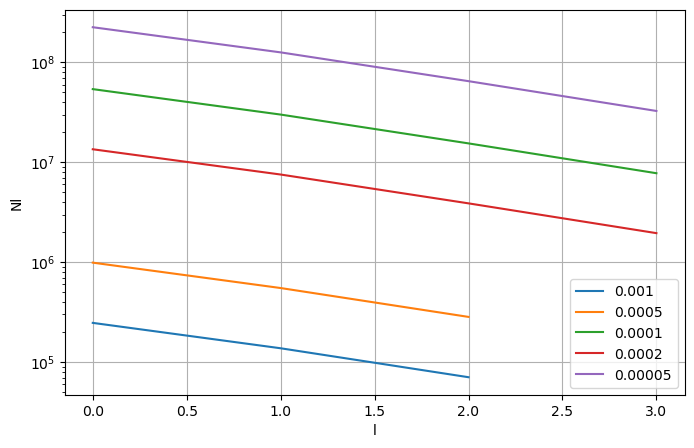

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(Nlist[0], label='0.001')
plt.plot(Nlist[1], label='0.0005')
plt.plot(Nlist[2], label='0.0001')
plt.plot(Nlist[3], label='0.0002')
plt.plot(Nlist[4], label='0.00005')

plt.xlabel("l")
plt.ylabel("Nl")
plt.yscale('log')
plt.legend()
plt.grid(True)


plt.show()

In [11]:
costs = []
for i in range(5):
    cost = Nlist[i][0]
    for j in range(1,len(Nlist[i])):
        cost += Nlist[i][j]*(M**j+M**(j-1))
    costs.append(cost*(errs[i]**2))

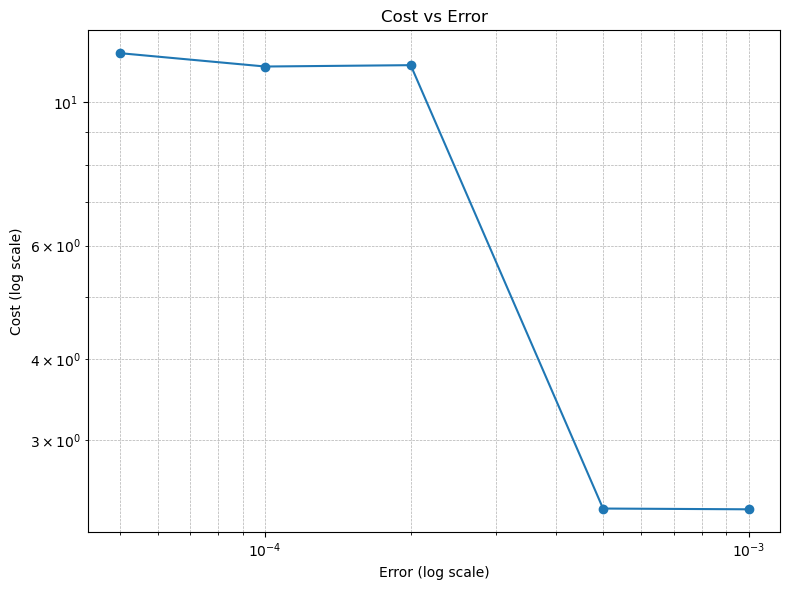

In [12]:
sorted_data = sorted(zip(errs, costs))
sorted_errs, sorted_costs = zip(*sorted_data)

sorted_errs = np.array(sorted_errs)
sorted_costs = np.array(sorted_costs)


plt.figure(figsize=(8, 6))
plt.loglog(sorted_errs, sorted_costs, marker='o', linestyle='-')  # log-log 图

plt.xlabel('Error (log scale)')
plt.ylabel('Cost (log scale)')
plt.title('Cost vs Error')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

## 1.2 Asian Option

$P = exp(-r)max(0, \bar S-1), where\, \bar S=\int ^1_0 S(t)dt$ approximated numerically by
$\bar S_l=\sum ^{N_l}_{n=1}\frac{1}{2}(\hat S_n + \hat S_{n-1})h_l$

In [ ]:
def sim_asian(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1, K=1):
    S = np.full((n_paths,), S0, dtype=np.float64)
    avg_S = np.zeros((n_paths,), dtype=np.float64)
    n_steps = int(T / dt)
    
    for i in range(1, n_steps + 1):
        S += r * S * dt + sigma * S * dW[i-1]
        avg_S += 0.5 * (S + np.roll(S, 1)) * dt 


    avg_S /= n_steps


    payoffs = np.exp(-r * T) * np.maximum(0, avg_S - K)
    

    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)

    return price, variance, payoffs

## 1.3 Lookback Option

$P = exp(-r)(S(1)-min\, S(t))$, approximated numerically by $\hat{S}_{\min, l} = \left( \min_n \hat{S}_n \right) \left( 1 - \beta^* \sigma \sqrt{h_l} \right)$

In [ ]:
def sim_lookback(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1):
    beta = 0.5826
    n_steps = int(T / dt)
    
    S = np.full(n_paths, S0, dtype=np.float64)
    min_S = np.full(n_paths, S0, dtype=np.float64)
    
    for i in range(n_steps):
        S += r * S * dt + sigma * S * dW[i]
        min_S = np.minimum(min_S, S)

    min_S_hat = min_S * (1 - beta * sigma * np.sqrt(dt))
    
    payoffs = np.exp(-r * T) * np.maximum(0, S - min_S_hat)
    
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)
    
    return price, variance, payoffs

## 1.4 Digital Option

$P = exp(-r)H(S(1)-1)$ ,where H(x) is the Heaviside function。

In [ ]:
def sim_digital(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1, K=1):
    S = np.full(n_paths, S0, dtype=np.float64)
    n_steps = int(T / dt)

    for i in range(n_steps):
        S += r * S * dt + sigma * S * dW[i]
    
    payoffs = np.exp(-r * T) * (S > K).astype(np.float64)
    
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)
    
    return price, variance, payoffs

# 2. Heston Stochastic Volatility Model

\begin{align*}
\mathrm{d}S &= rS\,\mathrm{d}t + \sqrt{V}S\,\mathrm{d}W_1, \quad 0 < t < 1, \\
\mathrm{d}V &= \lambda(\sigma^2 - V)\,\mathrm{d}t + \xi\sqrt{V}\,\mathrm{d}W_2,
\end{align*}

with $S(0) = 1$, $V(0) = 0.04$, $r = 0.05$, $\sigma = 0.2$, $\lambda = 5$, $\xi = 0.25$, and correlation $\rho = -0.5$ between $\mathrm{d}W_1$ and $\mathrm{d}W_2$.


The accuracy and variance are both improved by defining a new variable $W = e^{\lambda t}(V - \sigma^2)$,
and applying the Euler discretisation to the SDEs for $W$ and $S$, which results in the discrete equations
\begin{align*}
\hat{S}_{n+1} &= \hat{S}_n + r \hat{S}_n h + \sqrt{\hat{V}_n} \hat{S}_n \Delta W_{1,n}, \\
\hat{V}_{n+1} &= \sigma^2 + e^{-\lambda h} \left( \hat{V}_n - \sigma^2 \right) + \xi \sqrt{\hat{V}_n} \Delta W_{2,n}.
\end{align*}

In [ ]:
def sim_euro_heston(
    dW1, dW2, n_paths=NL, dt=h(0), S0=1, V0=0.04,
    r=0.05, sigma=0.2, lambd=5.0, xi=0.25, T=1, K=1
):
    n_steps = int(T / dt)

    S = np.full(n_paths, S0, dtype=np.float64)
    V = np.full(n_paths, V0, dtype=np.float64)

    # Precompute exponential decay factor
    exp_lambd_dt = np.exp(-lambd * dt)

    for i in range(n_steps):
        sqrt_V = np.sqrt(np.maximum(V, 0))
        S += r * S * dt + sqrt_V * S * dW1[i]

        V = sigma**2 + exp_lambd_dt * (V - sigma**2) + xi * sqrt_V * dW2[i]

    payoffs = np.exp(-r * T) * np.maximum(0, S - K)
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)

    return price, variance, payoffs

In [ ]:
def generate_correlated_dW(n_steps, n_paths, dt, rho=-0.5):
    dZ1 = np.random.randn(n_steps, n_paths)
    dZ2 = np.random.randn(n_steps, n_paths)
    
    dW1 = np.sqrt(dt) * dZ1
    dW2 = np.sqrt(dt) * (rho * dZ1 + np.sqrt(1 - rho**2) * dZ2)

    return dW1, dW2